# Projeto 02 –  Notebook 3: Regras de associação com Apriori

## Introdução

**Unidade Curricular:** Inteligência Artificial  
**Projeto:** Project 02 – Data Mining / Machine Learning  
**Notebook:** Regras de associação (Apriori)  

Este notebook apresenta o desenvolvimento realizado pelo Grupo 3 composto por Tiago Sousa (20735), Rodrigo Castro (23143), Rogério Gomes (27216), Paulo Costa (29851) e Lais Carvalho (51067)  no âmbito do trabalho prático da disciplina de Inteligência Artificial.

O objetivo deste projeto é aplicar técnicas de Mineração de Regras de Associação, em particular o algoritmo Apriori, para descobrir padrões de coocorrência entre pilotos que frequentemente partilharam o pódio ao longo do Campeonato Mundial de Fórmula 1 (1950–2020).

### Contexto e objetivo 
Este notebook complementa o trabalho de _clustering_ com K-Means, agora focando na **descoberta de padrões de associação** entre pilotos de Fórmula 1 através do algoritmo **Apriori**.

Vamos utilizar o mesmo dataset da Fórmula 1 (Kaggle – 1950 a 2020).

### Fórmula 1 como domínio de negócio

Enquanto desporto de alta competição e indústria multimilionária, a Fórmula 1 produz uma enorme quantidade de dados relacionados com corridas, equipas, pilotos, circuitos e resultados. A análise de coocorrências no pódio permite compreender:

1. rivalidades marcantes entre pilotos;

2. períodos de domínio de determinadas equipas;

3. combinações frequentes de pilotos que tendiam a estar juntos nos lugares cimeiros;

4. padrões característicos de determinadas épocas (por exemplo, anos de domínio da Ferrari, Red Bull ou Mercedes).

Objetivo do projeto

O foco do projeto é transformar os resultados das corridas numa perspetiva de “market basket analysis”, onde cada corrida é tratada como uma transação e cada piloto que termina no pódio é um item dessa transação. Com isso, o Apriori permite descobrir:

 conjuntos frequentes de pilotos que apareceram juntos nos pódios;

regras de associação que revelam relações como:

“Se o piloto X aparece no pódio, o piloto Y tende a aparecer também”;

níveis de suporte, confiança e lift que ajudam a quantificar a força dessas relações.

Este estudo permite compreender melhor o panorama competitivo da Fórmula 1 ao longo das décadas, identificar rivalidades históricas e revelar padrões que não são imediatamente visíveis apenas pelos resultados brutos.


In [9]:
# 1. Importação de bibliotecas


try:
    import pandas as pd
except ImportError:
    # Caso não esteja instalado, instalar pandas
    !pip install pandas
    import pandas as pd

import numpy as np

try:
    import matplotlib.pyplot as plt
except ImportError:
    # Caso não esteja instalado, instalar matplotlib
    !pip install matplotlib
    import matplotlib.pyplot as plt

# Tentativa de importação do Apriori a partir do mlxtend
try:
    from mlxtend.frequent_patterns import apriori, association_rules
except ImportError:
    # Caso não esteja instalado, instalar mlxtend
    !pip install mlxtend
    from mlxtend.frequent_patterns import apriori, association_rules

plt.style.use('seaborn-v0_8')  # se der erro, pode ser trocado para 'seaborn'


## 2. Carregamento do dataset

Vamos utilizar os mesmos ficheiros principais do projeto de K-Means:

- `drivers.csv` – informação base dos pilotos;
- `results.csv` – resultados de cada piloto em cada corrida;
- `races.csv` – informação sobre cada corrida (ano, nome, circuito, etc.).


In [10]:
# 2.1 Carregamento das tabelas principais
# Ajustar o caminho conforme a pasta onde colocaste os ficheiros CSV
# Exemplo: 'archive/drivers.csv' se usares a pasta 'archive'

drivers = pd.read_csv('drivers.csv')
constructors = pd.read_csv('constructors.csv')
circuits = pd.read_csv('circuits.csv')
continents = pd.read_csv('continents.csv')
results = pd.read_csv('results.csv')
races = pd.read_csv('races.csv')

drivers.head(), constructors.head(), circuits.head(), results.head(), races.head()


(   driverId   driverRef number code  forename     surname         dob  \
 0         1    hamilton     44  HAM     Lewis    Hamilton  1985-01-07   
 1         2    heidfeld     \N  HEI      Nick    Heidfeld  1977-05-10   
 2         3     rosberg      6  ROS      Nico     Rosberg  1985-06-27   
 3         4      alonso     14  ALO  Fernando      Alonso  1981-07-29   
 4         5  kovalainen     \N  KOV    Heikki  Kovalainen  1981-10-19   
 
   nationality                                             url  
 0     British     http://en.wikipedia.org/wiki/Lewis_Hamilton  
 1      German      http://en.wikipedia.org/wiki/Nick_Heidfeld  
 2      German       http://en.wikipedia.org/wiki/Nico_Rosberg  
 3     Spanish    http://en.wikipedia.org/wiki/Fernando_Alonso  
 4     Finnish  http://en.wikipedia.org/wiki/Heikki_Kovalainen  ,
    constructorId constructorRef        name nationality  \
 0              1        mclaren     McLaren     British   
 1              2     bmw_sauber  BMW Saube

### 2.2 Visão geral dos dados

In [11]:
print("drivers:")
drivers.info()

print("\nconstructors:")
constructors.info()

print("\ncircuits:")
circuits.info()

print("\nresults:")
results.info()

print("\nraces:")
races.info()


drivers:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   driverId     861 non-null    int64 
 1   driverRef    861 non-null    object
 2   number       861 non-null    object
 3   code         861 non-null    object
 4   forename     861 non-null    object
 5   surname      861 non-null    object
 6   dob          861 non-null    object
 7   nationality  861 non-null    object
 8   url          861 non-null    object
dtypes: int64(1), object(8)
memory usage: 60.7+ KB

constructors:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   constructorId   212 non-null    int64 
 1   constructorRef  212 non-null    object
 2   name            212 non-null    object
 3   nationality     212 non-null    object
 4

## 3. Preparação dos dados para o algoritmo Apriori

Para aplicar o Apriori, precisamos de um **conjunto de transações binárias**, onde:

- Cada linha representa uma **transação** (neste caso, uma corrida);
- Cada coluna representa um **item** (neste caso, um piloto);
- Os valores são 0/1 → se o piloto esteve ou não presente naquela transação.

### Estratégia adotada

1. Selecionar apenas **os pilotos que terminaram no pódio (posição 1, 2 ou 3)** em cada corrida;
2. Juntar com a tabela de `drivers` para obter o nome do piloto;
3. Transformar cada corrida (`raceId`) numa transação com os pilotos que ficaram no pódio;
4. Criar uma matriz _one-hot_ (0/1) com `raceId` nas linhas e nomes de pilotos nas colunas.


In [12]:
# 3.1 Converter a coluna 'position' para numérico (ignorando valores não numéricos)
from copyreg import constructor


results['position'] = pd.to_numeric(results['position'], errors='coerce')

# 3.2 Selecionar apenas pilotos no pódio (top 3)
podium_results = results[results['position'].between(1, 3, inclusive='both')].copy()

# 3.3 Juntar com drivers para obter o nome do piloto
podium_results = podium_results.merge(
    drivers[['driverId', 'forename', 'surname']],
    on='driverId',
    how='left'
)

#3.4 Criar coluna com nome da equipa
podium_results = podium_results.merge(
    constructors[['constructorId', 'name']],
    on='constructorId',
    how='left'
)
podium_results.rename(columns={'name': 'team'}, inplace=True)

#3.5 Criar coluna com nome da equipa

podium_results = podium_results.merge(
    races[['raceId', 'circuitId']],
    on='raceId',
    how='left'
)

#3.6 Criar coluna com nome do circuito
podium_results = podium_results.merge(
    circuits[['circuitId', 'name', 'country']],
    on='circuitId',
    how='left'
)
podium_results.rename(columns={'name': 'circuit'}, inplace=True)

#3.6 Criar coluna com o continente do circuito
podium_results = podium_results.merge(
    continents[['country', 'region']],
    on='country',
    how='left'
)
podium_results.rename(columns={'region': 'continent'}, inplace=True)

# Criar uma coluna com o nome completo do piloto
podium_results['driver_name'] = podium_results['forename'] + ' ' + podium_results['surname']

podium_results.head()


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,fastestLapSpeed,statusId,forename,surname,team,circuitId,circuit,country,continent,driver_name
0,1,18,1,1,22,1,1.0,1,1,10.0,...,218.300,1,Lewis,Hamilton,McLaren,1,Albert Park Grand Prix Circuit,Australia,Oceania,Lewis Hamilton
1,2,18,2,2,3,5,2.0,2,2,8.0,...,217.586,1,Nick,Heidfeld,BMW Sauber,1,Albert Park Grand Prix Circuit,Australia,Oceania,Nick Heidfeld
2,3,18,3,3,7,7,3.0,3,3,6.0,...,216.719,1,Nico,Rosberg,Williams,1,Albert Park Grand Prix Circuit,Australia,Oceania,Nico Rosberg
3,23,19,8,6,1,2,1.0,1,1,10.0,...,209.158,1,Kimi,Räikkönen,Ferrari,2,Sepang International Circuit,Malaysia,Asia,Kimi Räikkönen
4,24,19,9,2,4,4,2.0,2,2,8.0,...,208.033,1,Robert,Kubica,BMW Sauber,2,Sepang International Circuit,Malaysia,Asia,Robert Kubica


### 3.3 Criação da matriz de transações

Agora vamos transformar o conjunto de resultados em formato de **cesta de compras**:

- Índice: `raceId` (cada corrida)
- Colunas: `driver_name`
- Valores: 1 se o piloto esteve no pódio nessa corrida, 0 caso contrário.


In [13]:
# 3.4 Criar uma tabela de transações (raceId x driver_name)
basketDrivers = (
    podium_results
    .groupby(['raceId', 'driver_name'])['resultId']
    .count()
    .unstack(fill_value=0)
)

# Converter qualquer valor > 0 em 1 (presença/ausência)
basketDrivers = basketDrivers.applymap(lambda x: 1 if x > 0 else 0)

basketDrivers.head()


C:\Users\Paulo\AppData\Local\Temp\ipykernel_24548\3688911383.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basketDrivers = basketDrivers.applymap(lambda x: 1 if x > 0 else 0)


driver_name,Aguri Suzuki,Alain Prost,Alan Jones,Alberto Ascari,Alessandro Nannini,Alexander Albon,Alexander Wurz,Alfonso de Portago,Andrea de Cesaris,Art Cross,...,Tony Maggs,Trevor Taylor,Troy Ruttman,Umberto Maglioli,Valtteri Bottas,Vitaly Petrov,Vittorio Brambilla,Willy Mairesse,Wolfgang von Trips,Éric Bernard
raceId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# 3.5 Criar uma tabela de transações (raceId x team)
basketTeam = (
    podium_results
    .groupby(['raceId', 'team'])['resultId']
    .count()
    .unstack(fill_value=0)
)

# Converter qualquer valor > 0 em 1 (presença/ausência)
basketTeam = basketTeam.applymap(lambda x: 1 if x > 0 else 0)

basketTeam.head()


C:\Users\Paulo\AppData\Local\Temp\ipykernel_24548\2799604205.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basketTeam = basketTeam.applymap(lambda x: 1 if x > 0 else 0)


team,Alfa Romeo,AlphaTauri,Alpine F1 Team,Arrows,Aston Martin,BAR,BMW Sauber,BRM,Benetton,Brabham,...,Talbot-Lago,Team Lotus,Toleman,Toro Rosso,Toyota,Tyrrell,Vanwall,Watson,Williams,Wolf
raceId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# 3.6 Criar uma tabela de transações (raceId x team)
import pandas as pd

for df_tmp in [results, races, circuits, drivers, constructors]:
    if "url" in df_tmp.columns:
        df_tmp.drop(columns=["url"], inplace=True)
# --- Pódio ---
podium = results[results["positionOrder"].isin([1, 2, 3])]

# --- Joins ---
df = podium.merge(races, on="raceId") \
           .merge(circuits, on="circuitId") \
           .merge(drivers, on="driverId") \
           .merge(constructors, on="constructorId")

# --- Resultado ---
df["1st"] = (df["positionOrder"] == 1).astype(int)
df["2nd"] = (df["positionOrder"] == 2).astype(int)
df["3rd"] = (df["positionOrder"] == 3).astype(int)
df["P1_3"] = df["grid"].isin([1, 2, 3]).astype(int)

# --- Corredores ---
df["driver_col"] = "driver_" + df["surname"]
drivers_dummies = pd.get_dummies(df["driver_col"])

# --- Equipas ---
df["team_col"] = "team_" + df["name_y"]
teams_dummies = pd.get_dummies(df["team_col"])

# --- Continentes ---
df["country"]
country_to_continent = {
    # Europe
    "Italy": "Europe",
    "United Kingdom": "Europe",
    "France": "Europe",
    "Spain": "Europe",
    "Germany": "Europe",
    "Belgium": "Europe",
    "Monaco": "Europe",
    "Austria": "Europe",
    "Hungary": "Europe",
    "Netherlands": "Europe",
    "Portugal": "Europe",

    # America
    "USA": "America",
    "United States": "America",
    "Canada": "America",
    "Mexico": "America",
    "Brazil": "America",

    # Asia
    "Japan": "Asia",
    "China": "Asia",
    "Bahrain": "Asia",
    "Singapore": "Asia",
    "Azerbaijan": "Asia",
    "Saudi Arabia": "Asia",
    "Qatar": "Asia",
    "UAE": "Asia",

    # Oceania
    "Australia": "Oceania"
}
df["continent"] = df["country"].map(country_to_continent)

continent_dummies = pd.get_dummies(df["continent"])
continent_dummies = continent_dummies.reindex(
    columns=["America", "Europe", "Asia", "Oceania"],
    fill_value=0
)

# --- Dataset final ---
final_df = pd.concat([
    drivers_dummies,
    teams_dummies,
    df[["1st", "2nd", "3rd", "P1_3"]],
    continent_dummies
], axis=1)

#converte pra 1 ou 0, enves de true ou false
final_df = final_df.astype(int)


final_df.head()


,driver_Albon,driver_Alboreto,driver_Alesi,driver_Allison,driver_Alonso,driver_Amick,driver_Amon,driver_Anderson,driver_Andretti,driver_Arnoux,...,team_Zeltweg,team_Zolder,1st,2nd,3rd,P1_3,America,Europe,Asia,Oceania
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## 4. Aplicação do algoritmo Apriori

Com a matriz de transações preparada, podemos:

1. Aplicar o **Apriori** para encontrar **conjuntos frequentes de pilotos** que aparecem juntos no pódio;
2. Gerar **regras de associação** a partir desses conjuntos frequentes.

### 4.1 Descoberta de conjuntos frequentes

Vamos começar com um valor de suporte mínimo relativamente baixo (por exemplo `min_support = 0.01` = 1%), que significa:

> “O conjunto de pilotos aparece juntos em pelo menos 1% das corridas.”


In [16]:
# 4.1 Aplicar o Apriori para encontrar conjuntos frequentes
frequent_itemsets = apriori(
    basketDrivers,
    min_support=0.01,    # ajustar se necessário
    use_colnames=True
)

# Ordenar por suporte (do maior para o menor)
frequent_itemsets_sorted = frequent_itemsets.sort_values('support', ascending=False)

frequent_itemsets_sorted.head(20)


C:\Users\Paulo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mlxtend\frequent_patterns\fpcommon.py:175: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
45,0.179556,(Lewis Hamilton)
49,0.137778,(Michael Schumacher)
68,0.108444,(Sebastian Vettel)
48,0.099556,(Max Verstappen)
0,0.094222,(Alain Prost)
18,0.094222,(Fernando Alonso)
43,0.091556,(Kimi Räikkönen)
3,0.071111,(Ayrton Senna)
67,0.060444,(Rubens Barrichello)
73,0.059556,(Valtteri Bottas)


### 4.2 Geração de regras de associação

A partir dos conjuntos frequentes, vamos gerar **regras de associação**, medindo:

- **confidence** – quão frequentemente a consequência ocorre quando o antecedente acontece;
- **lift** – quanto a presença do antecedente aumenta a probabilidade da consequência, comparando com o acaso;
- **leverage** e **conviction** podem dar contexto adicional.

Vamos focar em regras com:

- `confidence >= 0.6` (60% ou mais)
- `lift > 1` (associação positiva)


In [17]:
# 4.2 Geração de regras de associação
rules = association_rules(
    frequent_itemsets,
    metric='confidence',
    min_threshold=0.6
)

# Filtrar por lift > 1 (associações positivas)
rules = rules[rules['lift'] > 1]

# Ordenar pelas regras mais interessantes (por exemplo, por lift e depois por confidence)
rules_sorted = rules.sort_values(['lift', 'confidence'], ascending=False)

rules_sorted.head(20)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
7,"(Fernando Alonso, Mark Webber)",(Sebastian Vettel),0.015111,0.108444,0.011556,0.764706,7.051591,1.0,0.009917,3.789111,0.871355,0.103175,0.736086,0.435632
1,(Lando Norris),(Max Verstappen),0.023111,0.099556,0.016000,0.692308,6.953984,1.0,0.013699,2.926444,0.876453,0.150000,0.658288,0.426511
4,(Mark Webber),(Sebastian Vettel),0.037333,0.108444,0.027556,0.738095,6.806206,1.0,0.023507,3.404121,0.886159,0.233083,0.706238,0.496097
5,(Sergio Pérez),(Max Verstappen),0.034667,0.099556,0.022222,0.641026,6.438874,1.0,0.018771,2.508381,0.875028,0.198413,0.601336,0.432120
8,"(Max Verstappen, Valtteri Bottas)",(Lewis Hamilton),0.022222,0.179556,0.017778,0.800000,4.455446,1.0,0.013788,4.102222,0.793182,0.096618,0.756230,0.449505
3,(Valtteri Bottas),(Lewis Hamilton),0.059556,0.179556,0.047111,0.791045,4.405571,1.0,0.036418,3.926413,0.821967,0.245370,0.745315,0.526711
2,(Nico Rosberg),(Lewis Hamilton),0.050667,0.179556,0.040000,0.789474,4.396821,1.0,0.030903,3.897111,0.813795,0.210280,0.743400,0.506123
6,(Rubens Barrichello),(Michael Schumacher),0.060444,0.137778,0.036444,0.602941,4.376186,1.0,0.028117,2.171523,0.821123,0.225275,0.539494,0.433729
10,"(Sebastian Vettel, Valtteri Bottas)",(Lewis Hamilton),0.015111,0.179556,0.010667,0.705882,3.931275,1.0,0.007953,2.789511,0.757070,0.057971,0.641514,0.382644
0,(Daniel Ricciardo),(Lewis Hamilton),0.028444,0.179556,0.019556,0.687500,3.828899,1.0,0.014448,2.625422,0.760459,0.103774,0.619109,0.398205


## 5. Interpretação dos resultados

Nesta secção, o objetivo é **analisar e interpretar** as regras obtidas.

Sugestões de análise (para preencher manualmente no relatório / notebook):

- Que pilotos aparecem frequentemente juntos no pódio?
- Há combinações características de determinadas épocas (anos 2000, 2010, etc.)?
- Existem regras do género:
  - “Se o piloto A está no pódio, o piloto B também costuma estar”?
- Há diferenças claras entre:
  - Pilotos da mesma equipa;
  - Pilotos de equipas rivais em determinados períodos;

> **Tarefa:** Escolher 3–5 regras com `lift` mais elevado e descrever o seu significado no contexto da Fórmula 1.


## 6. Visualizações simples (opcional)

Podemos criar alguns gráficos rápidos para ajudar a interpretar resultados.


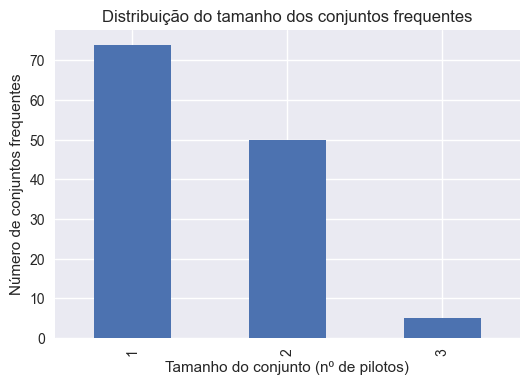

In [18]:
# 6.1 Distribuição do tamanho dos conjuntos frequentes
frequent_itemsets['itemset_size'] = frequent_itemsets['itemsets'].apply(len)

frequent_itemsets['itemset_size'].value_counts().sort_index().plot(
    kind='bar',
    figsize=(6,4)
)
plt.xlabel('Tamanho do conjunto (nº de pilotos)')
plt.ylabel('Número de conjuntos frequentes')
plt.title('Distribuição do tamanho dos conjuntos frequentes')
plt.show()


In [19]:
# 6.2 Top 10 regras por lift (visualização textual)
cols_to_show = ['antecedents', 'consequents', 'support', 'confidence', 'lift']

rules_top10 = rules_sorted.head(10)[cols_to_show].copy()

# Converter conjuntos imutáveis (frozenset) em strings legíveis
rules_top10['antecedents'] = rules_top10['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_top10['consequents'] = rules_top10['consequents'].apply(lambda x: ', '.join(list(x)))

rules_top10


,antecedents,consequents,support,confidence,lift
7,"Fernando Alonso, Mark Webber",Sebastian Vettel,0.011556,0.764706,7.051591
1,Lando Norris,Max Verstappen,0.016000,0.692308,6.953984
4,Mark Webber,Sebastian Vettel,0.027556,0.738095,6.806206
5,Sergio Pérez,Max Verstappen,0.022222,0.641026,6.438874
8,"Max Verstappen, Valtteri Bottas",Lewis Hamilton,0.017778,0.800000,4.455446
3,Valtteri Bottas,Lewis Hamilton,0.047111,0.791045,4.405571
2,Nico Rosberg,Lewis Hamilton,0.040000,0.789474,4.396821
6,Rubens Barrichello,Michael Schumacher,0.036444,0.602941,4.376186
10,"Sebastian Vettel, Valtteri Bottas",Lewis Hamilton,0.010667,0.705882,3.931275
0,Daniel Ricciardo,Lewis Hamilton,0.019556,0.687500,3.828899


## 7. Conclusão (a completar pelo grupo)

Sugestão de tópicos para a conclusão:

- O que foi possível descobrir com o algoritmo Apriori neste contexto?
- Que padrões entre pilotos são mais evidentes?
- Até que ponto as regras obtidas fazem sentido com o conhecimento prévio sobre a Fórmula 1?
- Limitações:
  - Nem todas as corridas têm 3 pilotos classificados no pódio (DNFs, etc.);
  - O modelo não distingue épocas, equipas ou condições externas;
  - Apenas considerámos presença conjunta no pódio, não a ordem (1.º, 2.º, 3.º).

> **Tarefa:** Escrever um parágrafo de conclusão relacionando os resultados do Apriori com os objetivos do projeto e com o domínio (F1).
